# Exploratory data analysis

## 1. Dataset description

1) Global COVID-19 datasets

- The two COVID-19 datasets, [the global confirmed dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) and [the global death dataset](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv), are from the [data repository](https://github.com/CSSEGISandData/COVID-19) for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). The dataset is updated every day starting from January 22nd, 2020.

- Both datasets contain columns of location information (`Province/State`, `Country/Region`, `Lat`, and `Long`) or daily accumulated numbers of confirmed or deaths in the corresponding location, starting from `1/22/20` to present.

- As stated in the dataset repository, "Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level. The US and other countries are at the country level."

- The datasets combine data from multiple sources and may contain mistakes.



## 2. Load the dataset

In [27]:
import requests, json
import numpy as np
import pandas as pd
import altair as alt
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate

alt.data_transformers.enable('json');
alt.renderers.enable('mimetype'); # Jupyter Lab 2.x

In [28]:
def simple_theme():
    return {
        "config": {
            "range": {"category": {"scheme": "category10"}}, # https://vega.github.io/vega/docs/schemes/#categorical
            "title": {
                "fontSize": 18,
            },
            "axisX": {
                "domain": True,
                "grid": False,
                "labelFontSize": 12,
                "labelAngle": 0, 
                "tickSize": 5,
                "titleFontSize": 14
            },
            "axisY": {
                "domain": False,
                "grid": True,
                "gridWidth": 1,
                "labelFontSize": 12,
                "labelAngle": 0, 
                "titleFontSize": 14
            },
            "legend": {
                "labelFontSize": 14,
                "titleFontSize": 14
            },
            "header": {
                "labelFontSize": 14,
                "titleFontSize": 14
            }
        }
    }

In [29]:
alt.themes.register('simple_theme', simple_theme)

# enable the newly registered theme
alt.themes.enable('simple_theme')

ThemeRegistry.enable('simple_theme')

In [4]:
params = {'function': 'FX_DAILY',
          'from_symbol': 'CAD',
          'to_symbol': 'USD',
          'outputsize': 'full',
          'apikey': os.environ['ALPHA_API']}
url = "https://www.alphavantage.co/query"
response = requests.get(url, params)

json_data = response.json()
    
# Check if the request was successful, if not raise an
# exception
if 'Error Message' in list(json_data.keys()):    
    raise Exception("Request failed.")

# Create the pandas dataframe (see: pd.read_json() )
data = pd.DataFrame(json_data[list(json_data.keys())[1]]).\
transpose().apply(pd.to_numeric).reset_index()

data.columns = ['date', 'open', 'high', 'low', 'close']
data.date = pd.to_datetime(data.date)

data.head()

In [5]:
data.head()

,date,open,high,low,close
0,2020-05-19,0.7168,0.7180,0.7154,0.7177
1,2020-05-18,0.7090,0.7173,0.7089,0.7173
2,2020-05-15,0.7114,0.7132,0.7079,0.7081
3,2020-05-14,0.7089,0.7124,0.7068,0.7117
4,2020-05-13,0.7104,0.7137,0.7080,0.7092


## 3. Explore the dataset

## 4. Initial thoughts


## 5. Wrangling

In [ ]:
# the following functions are borrowed from https://github.com/TomasBeuzen/machine-learning-tutorials/blob/master/ml-timeseries/notebooks/supervised_time_series_intro.ipynb
# Custom functions
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})


def ts_predict(input_data, model, n=20, responses=1):
    predictions = []
    n_features = input_data.size
    for _ in range(n):

        predictions = np.append(predictions,
                                model.predict(input_data.reshape(1, -1)))  # make prediction
        input_data = np.append(predictions[-responses:],
                               input_data[:n_features-responses])  # new input data
    return predictions.reshape((-1, responses))


def plot_ts(ax, df_train, df_test, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(df_test[col], '--', c=col_cycle[i], label = f'Validation {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+1)
    ax.set_title(f"Train Shape = {len(df_train)}, Validation Shape = {len(df_test)}",
                fontsize=16)
    ax.set_ylabel(df_train.columns[0])

        
def plot_forecast(ax, df_train, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], '-', c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+len(predictions))
    ax.set_title(f"{len(predictions)}-step forecast",
                    fontsize=16)
    ax.set_ylabel(response_cols)
    
def create_rolling_features(df, columns, windows=[6, 12]):
    for window in windows:
        df["rolling_mean_" + str(window)] = df[columns].rolling(window=window).mean()
        df["rolling_std_" + str(window)] = df[columns].rolling(window=window).std()
        df["rolling_var_" + str(window)] = df[columns].rolling(window=window).var()
        df["rolling_min_" + str(window)] = df[columns].rolling(window=window).min()
        df["rolling_max_" + str(window)] = df[columns].rolling(window=window).max()
        df["rolling_min_max_ratio_" + str(window)] = df["rolling_min_" + str(window)] / df["rolling_max_" + str(window)]
        df["rolling_min_max_diff_" + str(window)] = df["rolling_max_" + str(window)] - df["rolling_min_" + str(window)]

    df = df.replace([np.inf, -np.inf], np.nan)    
    df.fillna(0, inplace=True)
    return df

In [23]:
cad_to_usd = pd.merge(pd.DataFrame(pd.date_range(start='2018-01-01',
                                                 end=datetime.datetime.today()),
                                   columns=['date']),
                      data, how='left')

# data imputation with last observation carried over
cad_to_usd = cad_to_usd.fillna(method='ffill')

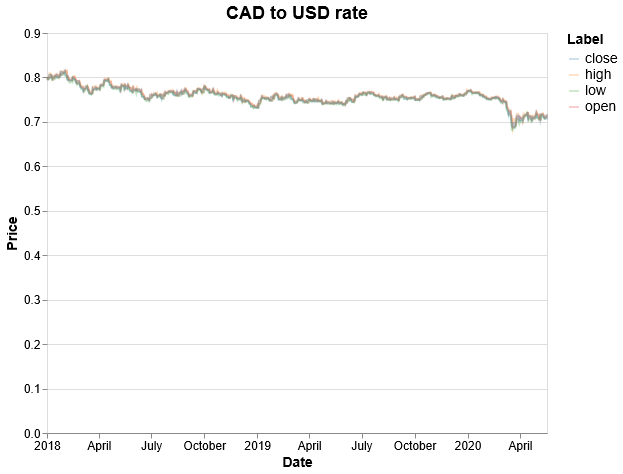

In [30]:
alt.Chart(
    pd.melt(cad_to_usd,
            id_vars=['date'],
            value_vars=['open', 'low', 'high', 'close'])
).encode(
    alt.X('date:T', title='Date'),
    alt.Y('value:Q', title='Price'),
    alt.Color('variable:N', title='Label')
).mark_line(
    opacity=0.3
).properties(
    height = 400,
    width = 500,
    title='CAD to USD rate'
)

In [34]:
data_lag = cad_to_usd[['date', 'close']].copy()
data_lag['y-1'] = data_lag['close'].shift(periods=1)

In [35]:
data_lag

,date,close,y-1
0,2018-01-01,0.7964,NaN
1,2018-01-02,0.7986,0.7964
2,2018-01-03,0.7972,0.7986
3,2018-01-04,0.8004,0.7972
4,2018-01-05,0.8059,0.8004
...,...,...,...
864,2020-05-14,0.7117,0.7092
865,2020-05-15,0.7081,0.7117
866,2020-05-16,0.7081,0.7081
867,2020-05-17,0.7081,0.7081


In [ ]:
split = int(data_lag.shape[0] * 0.7)
train, test = data_lag.iloc[: split], data_lag.iloc[split:]

## 6. Research questions



## 7. Data Analysis & Visualizations

## 8. Summary and conclusions
